In [2]:
pip install git+https://github.com/jkirkby3/pymle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jkirkby3/pymle to /tmp/pip-req-build-w6khx5or
  Running command git clone -q https://github.com/jkirkby3/pymle /tmp/pip-req-build-w6khx5or
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for PyMLE: filename=PyMLE-0.0.1-py3-none-any.whl size=38015 sha256=9664b64806f182c95713e77db2fdc3862a6afc9d8fac69a49a33fc05bbb7a642
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ru2en7p/wheels/cd/1e/47/b1240ec565910918e972d8bc400bc27859de0658a5cc94b937
Successfully built PyMLE


In [3]:
from pymle.models import OrnsteinUhlenbeck, CKLS
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import ExactDensity, EulerDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [18]:
def explicit_estimator(kappa, mu, sigma, x0, N, delta, param_bounds, guess):
  model = OrnsteinUhlenbeck()  
  model.params = np.array([kappa, mu, sigma])
  seed = None

  simulator = Simulator1D(S0=x0, M=N, dt=delta, model=model).set_seed(seed=seed)
  sample = simulator.sim_path()

  exact_est = AnalyticalMLE(sample, param_bounds, delta, density=ExactDensity(model)).estimate_params(guess)
  print(f'\nExact MLE: {exact_est}')
  
def theta_to_kms(theta1, theta2, theta3):
  kappa = theta2
  mu = theta1 / theta2
  sigma = theta3
  return kappa, mu, sigma

def Ornstein_Uhlenbeck_process(x0, delta_w, N, delta, kappa, mu, sigma, t):
  ito = 0
  x = np.zeros(N)
  x[0] = x0
  for i in range(1, N):
    ito += np.exp(kappa * t[i-1]) * delta_w[i]
    x[i] = mu + np.exp(- kappa * t[i]) * (x0 - mu + sigma * ito)
  return x

def eval_theta1_theta2_MLE(delta, x, n):
  kappa = - 1/delta * np.log(sum([x[i] * x[i-1] for i in range(1, n)])/sum([x[i]**2 for i in range(n-1)]))
  sigma_sq = 2* kappa / (n * (1 - np.exp(-2*delta*kappa))) * sum([(x[i] - x[i-1] * np.exp(- delta * kappa))**2 for i in range(1, n)])
  print(f"mle kappa : {kappa}")
  print(f"mle sigma : {sigma_sq**(1/2)}")

def eval_maximum_likelihood_estimators(delta, x, n):
  beta1 = ((n**(-1) * sum([x[i] * x[i-1] for i in range(1, n)])
            - n**(-2) * sum(x[1:n]) * sum(x[0:n-1])
            )
          / (n**(-1) * sum([x[i]**2 for i in range(n-1)])
            - n**(-2) * sum(x[:n-1])**2
            )
          )
  
  beta2 = n**(-1) * sum([x[i] - beta1 * x[i-1] for i in range(1, n)]) / (1 - beta1)
  beta3 = n**(-1) * sum([(x[i] - beta1 * x[i-1] - beta2 * (1 - beta1))**2 for i in range(1, n)])

  kappa = - delta**(-1) * np.log(beta1)  # rate of mean reversion
  mu = beta2  # long term level of process
  sigma_sq = 2 * kappa * beta3 * (1 - beta1**2)**(-1) # volatility

  print(f"mle kappa : {kappa}")
  print(f"mle mu : {mu}")
  print(f"mle sigma : {sigma_sq**(1/2)}")

def estimate_parameters(x0, x, N, delta, theta1, theta2, theta3, param_bounds, guess):
  kappa, mu, sigma = theta_to_kms(theta1, theta2, theta3)

  print("real kappa, mu, sigma = ", kappa, mu, sigma, "\n")
  if theta1 == 0:
    eval_theta1_theta2_MLE(delta, x, N)
  else:
    eval_maximum_likelihood_estimators(delta, x, N)
  print()
  explicit_estimator(kappa, mu, sigma, x0, N, delta, param_bounds, guess)


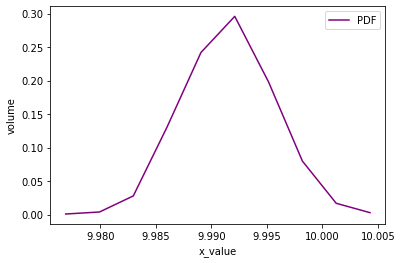

real kappa, mu, sigma =  1 3.0 2 

mle kappa : [0.15651886]
mle mu : [9.97749396]
mle sigma : [0.17669366]

Initial Params: [0.4 0.4 1.4]
Initial Likelihood: 1218.1794225401545
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 152, CG iterations: 89, optimality: 4.29e-07, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.91766102 3.99998946 1.96044385]
Final Likelihood: 1362.226953811121

Exact MLE: 
params      | [0.91766102 3.99998946 1.96044385] 
sample size | 1000 
likelihood  | 1362.226953811121 
AIC         | -2718.453907622242
BIC         | -2703.7306417852956


In [20]:
#task 1

def ou_random_number_generator(x, theta1, theta2, theta3, t, delta_w, N):
  ou_mean = theta1 / theta2 + (x - theta1 / theta2) * np.exp(- theta2 * t)
  ou_variance = theta3**2 / (2 * theta2) * (1 - np.exp(- 2 * theta2 * t))
  return np.random.normal(ou_mean, ou_variance, 1)

def find_MLE_of_the_random_process():
  theta1 = 3
  theta2 = 1
  theta3 = 2

  param_bounds = [(0.01, 4), (0.01, 4.0), (0.01, 2.5)]
  guess = np.array([0.4, 0.4, 1.4])

  x0 = 10  
  N = 1000
  T = 1
  t = np.linspace(0, T, N)
  delta = T / N
  z = np.random.normal(0, 1, N)
  delta_w = z * np.sqrt(delta)

  ou_random_numbers = []
  for i in range(1, 1001):
    ou_random_numbers.append(ou_random_number_generator(x0, theta1, theta2, theta3, delta, delta_w, N))

  ou_count, ou_bins_count = np.histogram(ou_random_numbers)
  ou_pdf = ou_count / sum(ou_count)
  plt.plot(ou_bins_count[:-1], ou_pdf, label="PDF", color="purple")
  plt.legend()
  plt.ylabel('volume')
  plt.xlabel('x_value')
  plt.show()

  estimate_parameters(x0, ou_random_numbers, N, delta, theta1, theta2, theta3, param_bounds, guess)

find_MLE_of_the_random_process()

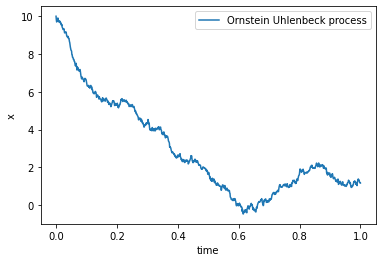

real kappa, mu, sigma =  3 0.0 2 

mle kappa : 3.372738367532808
mle sigma : 2.0568709106286853

Initial Params: [0.2 0.  1.4]
Initial Likelihood: 1175.1499902739479
`gtol` termination condition is satisfied.
Number of iterations: 22, function evaluations: 72, CG iterations: 31, optimality: 7.05e-07, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [2.59316604 0.         1.9764617 ]
Final Likelihood: 1354.9266760013732

Exact MLE: 
params      | [2.59316604 0.         1.9764617 ] 
sample size | 1000 
likelihood  | 1354.9266760013732 
AIC         | -2703.8533520027463
BIC         | -2689.1300861658


In [19]:
#task 2 

def find_MLE_of_the_process():
  x0 = 10  
  N = 1000
  T = 1
  t = np.linspace(0, T, N)
  delta = T / N
  z = np.random.normal(0, 1, N)
  delta_w = z * np.sqrt(delta)
  theta1 = 0
  theta2 = 3
  theta3 = 2

  kappa, mu, sigma = theta_to_kms(theta1, theta2, theta3)
  param_bounds = [(0.01, 4), (0.0, 0.0), (0.01, 2.5)]
  guess = np.array([0.2, 0.0, 1.4])

  x = Ornstein_Uhlenbeck_process(x0, delta_w, N, delta, kappa, mu, sigma, t)
  plt.plot(t, x, label = 'Ornstein Uhlenbeck process')
  plt.xlabel('time')
  plt.ylabel('x')
  plt.legend()
  plt.show()
  estimate_parameters(x0, x, N, delta, theta1, theta2, theta3, param_bounds, guess)

find_MLE_of_the_process()

In [22]:
#task 3 - (CKLS) model, Euler method, estimate parametrs and compute confidence intervals

def eueler_estimator(theta1, theta2, theta3, theta4, x0, N, delta):
  model = CKLS()  
  model.params = np.array([theta1, theta2, theta3, theta4])
  seed = None  

  simulator = Simulator1D(S0=x0, M=N, dt=delta, model=model).set_seed(seed=seed)
  sample = simulator.sim_path()


  param_bounds = [(0.01, 4), (0.1, 3.0), (0.01, 2.5), (0.01, 2.5)] # Set the parameter bounds for fitting  (kappa, mu, sigma)
  guess = np.array([0.2, 1.3, 0.1, 0.1]) # Choose some initial guess for params fit

  euler_est = AnalyticalMLE(sample, param_bounds, delta, density=EulerDensity(model)).estimate_params(guess)
  return euler_est.params
  
x0 = 2
N = 10000
delta = 0.0001
theta1 = 1
theta2 = 2
theta3 = 0.5
theta4 = 0.3

theta1_values = []
theta2_values = []
theta3_values = []
theta4_values = []
for i in range(10):
  euler_est = eueler_estimator(theta1, theta2, theta3, theta4, x0, N, delta)
  theta1_values.append(euler_est[0])
  theta2_values.append(euler_est[1])
  theta3_values.append(euler_est[2])
  theta4_values.append(euler_est[3])

print(stats.t.interval(0.95, df=len(theta1_values)-1, loc=np.mean(theta1_values), scale=stats.sem(theta1_values)))
print(stats.t.interval(0.95, df=len(theta2_values)-1, loc=np.mean(theta2_values), scale=stats.sem(theta2_values)))
print(stats.t.interval(0.95, df=len(theta3_values)-1, loc=np.mean(theta3_values), scale=stats.sem(theta3_values)))
print(stats.t.interval(0.95, df=len(theta4_values)-1, loc=np.mean(theta4_values), scale=stats.sem(theta4_values)))

Initial Params: [0.2 1.3 0.1 0.1]
Initial Likelihood: -156427.6135646423


/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 290, CG iterations: 168, optimality: 2.84e-04, constraint violation: 0.00e+00, execution time: 0.65 s.
Final Params: [1.83843709 1.6797274  0.50525838 0.28888839]
Final Likelihood: 33607.71727301592
Initial Params: [0.2 1.3 0.1 0.1]
Initial Likelihood: -141529.15186828814
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 345, CG iterations: 177, optimality: 9.39e-05, constraint violation: 0.00e+00, execution time: 0.76 s.
Final Params: [0.01002184 2.15865482 0.49932877 0.30323839]
Final Likelihood: 34288.79661573828
Initial Params: [0.2 1.3 0.1 0.1]
Initial Likelihood: -157333.13748141195
`xtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 315, CG iterations: 193, optimality: 1.29e-04, constraint violation: 0.00e+00, execution time: 0.71 s.
Final Params: [0.97286509 1.86622485 0.51019074 0.28623398]
Final Likelihood: 